<a href="https://colab.research.google.com/github/tanpinray/ELEC0134-AMLS-CW/blob/main/Task_B_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import libraries
The required libraries for this notebook are list below. If using google colab, change the value in 'google_colab' to True

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import os
import shutil
import random
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Libraries for image preprocessing, data augmentation 
from skimage.io import imread, imsave, imshow
import imgaug.augmenters as iaa

# Libraries for Convolutional Neural Network (CNN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model

# Library for assessing model performance
from sklearn import metrics

# If using google colab, change to True
google_colab = False

if google_colab:
    # For google colab
    from google.colab import drive
    drive.mount('/content/drive')
else:
    pass

# 2 Data Preprocessing

## 2.1 Separate training images by classes
Directories for each class was created and images are moved into the respective directory

In [ ]:
if google_colab:
    # For google colab
    train_path = '/content/drive/My Drive/dataset'
    train_datapath = '/content/drive/My Drive/dataset/image'
    # New path for seperating images into respective classes
    new_train_path = os.path.join(train_path, 'image_classes')
else:
    # For offline use
    train_path = './dataset'
    train_datapath = './dataset/image'
    # New path for seperating images into respective classes
    new_train_path = os.path.join(train_path, 'image_classes')


# Read csv file with image name and associated labels
df_train = pd.read_csv(os.path.join(train_path, 'label.csv'))

if os.path.exists(new_train_path):
    print('The directory with images sorted by classes already exists')
else:
    os.mkdir(new_train_path)
    # Make a directory for images separated into classes
    for label in df_train['label'].unique():
        os.mkdir(os.path.join(new_train_path, label))

    # Move images into new directories
    for filename in tqdm(df_train['file_name']):
        idx = df_train.index[df_train['file_name'] == filename].item()
        if df_train.loc[idx, 'label'] == 'no_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'no_tumor'))
        elif df_train.loc[idx, 'label'] == 'glioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'glioma_tumor'))
        elif df_train.loc[idx, 'label'] == 'meningioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'meningioma_tumor'))
        elif df_train.loc[idx, 'label'] == 'pituitary_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'pituitary_tumor'))

The directory with images sorted by classes already exists


## 2.2 Augment training images
Augment the images by rotating it, flipping it horizontally, adding gaussian blur, shearing, sharpening and blurring edges.
This was only done for images with no tumor to balance the training dataset

In [ ]:
# New path for seperating images into respective classes
aug_train_path = os.path.join(train_path, 'image_classes_aug')

aug_no_tumor_path = os.path.join(aug_train_path, 'no_tumor')
aug_glioma_tumor_path = os.path.join(aug_train_path, 'glioma_tumor')
aug_meningioma_tumor_path = os.path.join(aug_train_path, 'meningioma_tumor')
aug_pituitary_tumor_path = os.path.join(aug_train_path, 'pituitary_tumor')

if os.path.exists(aug_train_path):
    print('The directory with augmented images sorted by classes already exists')
else:
    os.mkdir(aug_train_path)
    # Make a directory for images separated into classes
    for label in df_train['label'].unique():
        os.mkdir(os.path.join(aug_train_path, label))

    # Move images into new directories
    for filename in tqdm(df_train['file_name']):
        idx = df_train.index[df_train['file_name'] == filename].item()
        if df_train.loc[idx, 'label'] == 'no_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_no_tumor_path)
        elif df_train.loc[idx, 'label'] == 'glioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_glioma_tumor_path)
        elif df_train.loc[idx, 'label'] == 'meningioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_meningioma_tumor_path)
        elif df_train.loc[idx, 'label'] == 'pituitary_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_pituitary_tumor_path)

    images = []
    for filename in tqdm(df_train['file_name']):
        # obtain pixel data from the image
        im = imread(os.path.join(train_datapath, filename))
        images.append(im)

    # Index of images with no_tumor label
    noTumor_idx = df_train.index[df_train['label'] == 'no_tumor'].tolist()

    # List of images with no_tumor label
    images_noTumor = []
    for idx in noTumor_idx:
        images_noTumor.append(images[idx])

    # Data Augmentation
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5)),
            iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
        ),
        iaa.Affine(
            rotate=(-180, 180),
            shear=(-10, 10)
        )
    ], random_order=True)

    image_number = 3000
    # Double the no_tumor images
    images_aug_noTumor = seq(images=images_noTumor)
    for image in tqdm(images_aug_noTumor):
        image_filename = f'IMAGE_{image_number}.jpg'
        imsave(os.path.join(aug_no_tumor_path, image_filename), image)
        image_number += 1

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

## 2.3 Separate test images by classes
Directories for each class was created and images are moved into the respective directory

In [ ]:
if google_colab:
    # For google colab
    test_path = '/content/drive/My Drive/test'
    test_datapath = '/content/drive/My Drive/test/image'
    new_test_path = os.path.join(test_path, 'image_classes')
else:
    # For offline use
    test_path = './test'
    test_datapath = './test/image'
    new_test_path = os.path.join(test_path, 'image_classes')


# Read csv file with image name and associated labels
df_test = pd.read_csv(os.path.join(test_path, 'label.csv'))

if os.path.exists(new_test_path):
    print('The directory with images sorted by classes already exists')
else:
  os.mkdir(new_test_path)
  # Make a directory for images separated into classes
  for label in df_test['label'].unique():
    os.mkdir(os.path.join(new_test_path, label))
  
  # Move images into new directories
  for filename in tqdm(df_test['file_name']):
    idx = df_test.index[df_test['file_name']==filename].item()
    if df_test.loc[idx, 'label'] == 'no_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'no_tumor'))
    elif df_test.loc[idx, 'label'] =='glioma_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'glioma_tumor'))
    elif df_test.loc[idx, 'label'] =='meningioma_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'meningioma_tumor'))
    elif df_test.loc[idx, 'label'] =='pituitary_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'pituitary_tumor'))
    

The directory with images sorted by classes already exists


## 2.4 Create train, validation and test dataset
Change the value of 'augmentation' to True if using augmented images

In [ ]:
augmentation = False

if augmentation:
    datapath = aug_train_path
else:
    datapath = new_train_path

batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  labels='inferred', 
  label_mode='int',
  validation_split=0.2,
  subset="training",
  shuffle = True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  labels='inferred', 
  label_mode='int',
  validation_split=0.2,
  subset="validation",
  shuffle = True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_test_path,
  labels='inferred', 
  label_mode='int',
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3454 files belonging to 4 classes.
Using 2764 files for training.
Found 3454 files belonging to 4 classes.
Using 690 files for validation.
Found 200 files belonging to 4 classes.


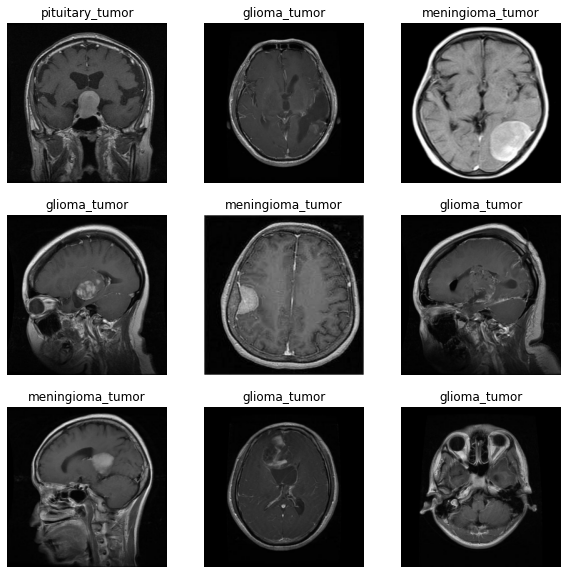

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 4 Training and Testing Model

## 4.1 Create model
Import Xception architecture as base model and supplement it with pooling layer, dropout layer, and a fully connected layer with softmax activation

In [ ]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()

# Import pre-trained Xception architecture as base model
base_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Display output of base model
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

83697664/83683744 [==============================] - 1s 0us/step
(32, 8, 8, 2048)


In [ ]:
# Freeze the convolutional base before compile and train the model.
# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
# Xception needs to scale input pixels between -1 and 1
x = tf.keras.applications.xception.preprocess_input(inputs)
# Initialise the pre-trained Xception model
# Setting training=false freezes training on batch normalization layers
x = base_model(x, training=False)
# Convert the features to a single 2048-element vector per image
pool_layer = layers.GlobalAveragePooling2D()(x)
# Regularize with dropout
drop_layer = layers.Dropout(0.2)(pool_layer)
# Prediction layer
outputs = layers.Dense(4, activation='softmax')(drop_layer)
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

## 4.2 Train model
Model was first trained with 30 epochs initially. If the validation loss does not improve in 3 epochs, the training stops

In [ ]:
# First 30 epochs fitted without fine tuning
initial_epochs = 30

# If validation loss does not improve for 3 epochs, stop fitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

if google_colab:
    # For google colab
    model_path = '/content/drive/My Drive/saved_models'
else:
    # For offline use
    model_path = './saved_models'


if os.path.exists(model_path):
    print('The directory for saved models already exists')
else:
  os.mkdir(model_path)

# Save model weights when accuracy is the best
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_path, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Fit the model
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[early_stop, model_checkpoint_callback])

The directory for saved models already exists
Epoch 1/30
87/87 [==============================] - 56s 580ms/step - loss: 0.8784 - accuracy: 0.6523 - val_loss: 0.6713 - val_accuracy: 0.7681
Epoch 2/30
87/87 [==============================] - 47s 538ms/step - loss: 0.5997 - accuracy: 0.7912 - val_loss: 0.5699 - val_accuracy: 0.8029
Epoch 3/30
87/87 [==============================] - 48s 538ms/step - loss: 0.5191 - accuracy: 0.8187 - val_loss: 0.5106 - val_accuracy: 0.8275
Epoch 4/30
87/87 [==============================] - 48s 539ms/step - loss: 0.4651 - accuracy: 0.8412 - val_loss: 0.4775 - val_accuracy: 0.8377
Epoch 5/30
87/87 [==============================] - 47s 535ms/step - loss: 0.4323 - accuracy: 0.8542 - val_loss: 0.4574 - val_accuracy: 0.8377
Epoch 6/30
87/87 [==============================] - 48s 540ms/step - loss: 0.4179 - accuracy: 0.8549 - val_loss: 0.4280 - val_accuracy: 0.8594
Epoch 7/30
87/87 [==============================] - 47s 533ms/step - loss: 0.3890 - accuracy: 0.

## 4.3 Fine tune model
The convolutional layers in the Xception architecture was unfrozen and the model was fine tuned with 10 epochs. The learning rate was decreased to 0.00001, and decays exponentially

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
initial_epochs = history.epoch
# Fine tune model for another 10 epochs
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# This function keeps the initial learning rate for the first epoch
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < initial_epochs:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs[-1],
                         validation_data=val_ds,
                         callbacks=[early_stop, lr_decay, model_checkpoint_callback])

Epoch 30/40
87/87 [==============================] - 175s 2s/step - loss: 0.1808 - accuracy: 0.9389 - val_loss: 0.2952 - val_accuracy: 0.9000 - lr: 1.0000e-05
Epoch 31/40
87/87 [==============================] - 165s 2s/step - loss: 0.0806 - accuracy: 0.9768 - val_loss: 0.2679 - val_accuracy: 0.9087 - lr: 9.0484e-06
Epoch 32/40
87/87 [==============================] - 165s 2s/step - loss: 0.0488 - accuracy: 0.9877 - val_loss: 0.2704 - val_accuracy: 0.9072 - lr: 8.1873e-06
Epoch 33/40
87/87 [==============================] - 166s 2s/step - loss: 0.0310 - accuracy: 0.9924 - val_loss: 0.2661 - val_accuracy: 0.9188 - lr: 7.4082e-06
Epoch 34/40
87/87 [==============================] - 167s 2s/step - loss: 0.0193 - accuracy: 0.9964 - val_loss: 0.2578 - val_accuracy: 0.9188 - lr: 6.7032e-06
Epoch 35/40
87/87 [==============================] - 165s 2s/step - loss: 0.0115 - accuracy: 0.9982 - val_loss: 0.2687 - val_accuracy: 0.9174 - lr: 6.0653e-06
Epoch 36/40
87/87 [===========================

## 4.4 Plot training and validation accuracy and loss

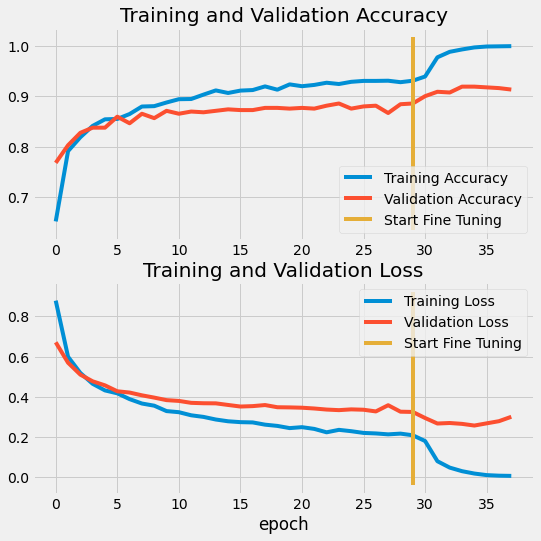

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4.5 Test model accuracy using test dataset
The confusion matrix and classification report was used to evaluate performance

  0%|          | 0/7 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.81      0.86        43
meningioma_tumor       0.85      0.91      0.88        68
        no_tumor       0.95      0.97      0.96        37
 pituitary_tumor       0.94      0.92      0.93        52

        accuracy                           0.91       200
       macro avg       0.91      0.91      0.91       200
    weighted avg       0.91      0.91      0.90       200



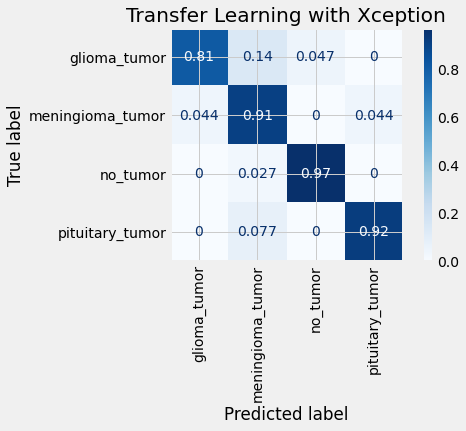

In [ ]:
predictions = np.array([])
labels =  np.array([])
# Obtain the predictions from test dataset
for x, y in tqdm(test_ds):
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()])


disp = metrics.ConfusionMatrixDisplay.from_predictions(
        labels,
        predictions,
        display_labels = test_ds.class_names,
        xticks_rotation = 'vertical',
        cmap=plt.cm.Blues,
        normalize='true'
    )

disp.ax_.set_title('Transfer Learning with Xception')
plt.show

print(metrics.classification_report(
    labels, predictions, target_names=test_ds.class_names))